In [1]:
#Primero importamos algunas librerias
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geemap,ee
import matplotlib.colors as colors
from shapely.geometry import shape, box
from matplotlib import colors
import matplotlib.patches as mpatches
from shapely.geometry import MultiPolygon
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
import os

In [2]:
ee.Authenticate()
# ee.Initialize(project='ee-ccamz2')
ee.Initialize(project='ee-tomasroar')

In [3]:
# Seleccionamos rango de fechas
startDate= '2024-01-01'
endDate = '2025-01-01'

# Observatorios

Cargamos el mapa de Chile, seleccionamos las regiones que nos interesan, y eliminamos las islas del mapa

In [4]:
chile = gpd.read_file('Datos/Comunas/Comunas.shp').to_crs(epsg=4326)#.to_crs(epsg=32719)
chile = chile[chile['codregion'].isin([2, 3, 4, 5, 13])]
#quitamos isla de pascua y juan fernandez<
chile = chile[~chile['Comuna'].isin(['Isla de Pascua', 'Juan Fernández'])]
chile.head(5)

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
26,330,13987.326781,10,7,13129,13,1.424341e+07,16812.167615,Región Metropolitana de Santiago,San Joaquín,Santiago,"POLYGON ((-70.62342 -33.47338, -70.62292 -33.4..."
36,331,13311.641304,13,7,13130,13,1.389538e+07,15988.816037,Región Metropolitana de Santiago,San Miguel,Santiago,"POLYGON ((-70.63659 -33.51873, -70.6374 -33.51..."
46,66,134800.837330,5,5,4103,4,6.897651e+08,156310.933278,Región de Coquimbo,Andacollo,Elqui,"POLYGON ((-71.12438 -30.11141, -71.12418 -30.1..."
47,332,11733.486710,13,7,13131,13,9.056280e+06,14061.528858,Región Metropolitana de Santiago,San Ramón,Santiago,"POLYGON ((-70.63811 -33.51868, -70.6374 -33.51..."
57,309,11488.695747,9,7,13108,13,1.068637e+07,14088.417488,Región Metropolitana de Santiago,Independencia,Santiago,"POLYGON ((-70.65817 -33.39914, -70.65827 -33.3..."


In [5]:
#Funcion dada por chatGpt para eliminar las islas y podamos plotear correctamente Chile continental
def keep_only_mainland(geom):
    if geom.geom_type == 'Polygon':
        return geom
    elif geom.geom_type == 'MultiPolygon':
        # Se queda con el polígono de mayor área
        largest = max(geom.geoms, key=lambda g: g.area)
        return largest
    else:
        return geom

In [6]:
# Aplicar a todas las geometrías
chile['geometry'] = chile['geometry'].apply(keep_only_mainland)

Cargamos los observatorios en Chile

In [7]:
obs = gpd.read_file('Datos/observatorios_filtrados/observatorios_filtrados.shp').to_crs(epsg=4326)
obs

,Nombre,Altitud (m,Ubicación,Tipo,Estado,Año de In,Área Lent,geometry
0,ALMA,5000,"Llano de Chajnantor, Antofagasta",Radio,Operativo,2003,41001.06121734071,POINT (-67.7546 -23.0221)
1,APEX,5100,"Llano de Chajnantor, Antofagasta",Radio,Operativo,2003,113.09733552923257,POINT (-67.7533 -23.0056)
2,ACT,5190,"Cerro Toco, Antofagasta",Radio,Operativo,2007,28.274333882308134,POINT (-67.7875 -22.9583)
3,Paranal (VLT),2635,"Cerro Paranal, Antofagasta",Óptico/Infrarrojo,Operativo,1991,211.23836840423655,POINT (-70.4042 -24.6272)
4,ELT (en construcción),3046,"Cerro Armazones, Antofagasta",Óptico/Infrarrojo,En construcción,2014,1194.690595328151,POINT (-70.19 -24.5895)
5,La Silla,2400,"Cerro La Silla, Coquimbo",Óptico,Operativo,1964,10.179015632055895,POINT (-70.7347 -29.2581)
6,Cerro Tololo (CTIO),2200,"Cerro Tololo, Coquimbo",Óptico,Operativo,1963,12.566370614359172,POINT (-70.8061 -30.1692)
7,Gemini Sur,2737,"Cerro Pachón, Coquimbo",Óptico/Infrarrojo,Operativo,1994,51.51838900400386,POINT (-70.7366 -30.2407)
8,Vera C. Rubin Observatory,2663,"Cerro Pachón, Coquimbo",Óptico,En construcción,2014,55.41985163906199,POINT (-70.7492 -30.2444)
9,Magellan (Las Campanas),2400,"Cerro Las Campanas, Atacama",Óptico,Operativo,1999,66.46813142637272,POINT (-70.6925 -29.0144)


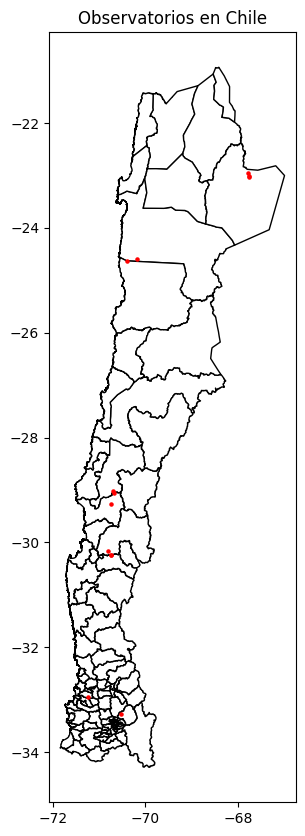

In [8]:
chile.to_crs(obs.crs, inplace=True)
chile.plot(color='white', edgecolor='black', figsize=(10, 10))
obs.plot(ax=plt.gca(), color='red', markersize=5)
plt.title('Observatorios en Chile')
plt.show()

In [9]:
# Convert chile.total_bounds to a polygon: [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = chile.total_bounds
xy = [[ [minx, miny],
        [minx, maxy],
        [maxx, maxy],
        [maxx, miny],
        [minx, miny] 
]]
aoi = ee.Geometry.Polygon(xy)
center = aoi.centroid().getInfo()['coordinates']
aoi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -71.84324926038242,
              -34.29066938312955
            ],
            [
              -71.84324926038242,
              -20.934544567217234
            ],
            [
              -66.99017820921081,
              -20.934544567217234
            ],
            [
              -66.99017820921081,
              -34.29066938312955
            ],
            [
              -71.84324926038242,
              -34.29066938312955
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [10]:
def descargar_imagen(image, vis_params, output):
    # Obtener la URL de la imagen visualizada
    image_url = image.visualize(**vis_params).getThumbURL({
        'dimensions': 1024,  # Tamaño máximo de la imagen
        'region': aoi.bounds(),
        'format': 'png'
    })
    # Descargar la imagen
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Guardar localmente
    img.save(f'{output}.png')

## Contaminacion Luminica
[VIIRS Stray Light Corrected Nighttime](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG?hl=es-419)

In [11]:
collection = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")  \
	.filterDate(startDate, endDate) \
	.map(lambda img: img.clip(aoi))

# Selecciona la banda de intensidad de luces nocturnas
image = collection.select('avg_rad')

# Selecciona la imagen promedio del año
image = image.median()

# Define parámetros de visualización
vis_params = {
    'min': 0,
    'max': 60,
    'palette': ['000000', 'ffff00', 'ffffff']
}

In [12]:
descargar_imagen(image, vis_params, "Contaminacion Luminica")

In [13]:
# Crea un mapa interactivo
# Map = geemap.Map(center=[20, 0], zoom=2)
# Map.addLayer(image, vis_params, 'Luces nocturnas (promedio)')
# Map.addLayerControl()
# Map

## Nubosidad
[Terra Atmosphere Monthly Global Product](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD08_M3?hl=es-419)

In [14]:
# Cargar colección de MODIS Atmosférico mensual
collection = ee.ImageCollection("MODIS/061/MOD08_M3") \
    .filterDate(startDate, endDate) \
    # .map(lambda img: img.clip(aoi))

# Calcular el promedio en el rango de fechas
image = collection.mean()

# Seleccionar la banda de fracción de nubes (útil para evaluar cielos despejados)
image = image.select('Cirrus_Fraction_SWIR_FMean')

# Parámetros de visualización (nubosidad entre 0 y 1)
vis_params = {
    'min': 0,
    'max': 10000,
    'palette': ['000000', '8888ff', 'ffffff']  # de cielo despejado a nublado
}

# Añadir la capa al mapa
# Map.addLayer(image, vis_params, 'Nubosidad promedio (MODIS)')
# Map.addLayerControl()
# Map


In [15]:
# Cargar colección de MODIS Atmosférico mensual
collection = ee.ImageCollection("MODIS/061/MOD08_M3") \
    .filterDate(startDate, endDate) \
    # .map(lambda img: img.clip(aoi))

# Calcular el promedio en el rango de fechas
image = collection.mean()

# Seleccionar la banda de fracción de nubes (útil para evaluar cielos despejados)
image = image.select('Cloud_Optical_Thickness_Liquid_Log_Mean_Mean')

# Parámetros de visualización (nubosidad entre 0 y 1)
vis_params = {
    'min': 0,
    'max': 4176,
    'palette': ['000000', '8888ff', 'ffffff']  # de cielo despejado a nublado
}

# Añadir la capa al mapa
# Map.addLayer(image, vis_params, 'Muestra')
# Map.addLayerControl()
# Map


In [16]:
# Cargar colección de MODIS Atmosférico mensual
collection = ee.ImageCollection("MODIS/061/MOD08_M3") \
    .filterDate(startDate, endDate) \
    # .map(lambda img: img.clip(aoi))

# Calcular el promedio en el rango de fechas
image = collection.mean()

# Seleccionar la banda de fracción de nubes (útil para evaluar cielos despejados)
image = image.select('Cloud_Optical_Thickness_Liquid_Mean_Uncertainty')

# Parámetros de visualización (nubosidad entre 0 y 1)
vis_params = {
    'min': 0,
    'max': 2000,
    'palette': ['000000', '8888ff', 'ffffff']  # de cielo despejado a nublado
}

# Añadir la capa al mapa
# Map.addLayer(image, vis_params, 'Muestra')
# Map.addLayerControl()
# Map


In [17]:
# Cargar colección de MODIS Atmosférico mensual
collection = ee.ImageCollection("MODIS/061/MOD08_M3") \
    .filterDate(startDate, endDate) \
    .map(lambda img: img.clip(aoi))

# Calcular el promedio en el rango de fechas
image = collection.median()

# Seleccionar la banda de fracción de nubes (útil para evaluar cielos despejados)
image = image.select('Cirrus_Fraction_SWIR_FStd').clip(aoi)

# Parámetros de visualización (nubosidad entre 0 y 1)
vis_params = {
    'min': 0,
    'max': 10000,
    'palette': ['000000', '8888ff', 'ffffff']  # de cielo despejado a nublado
}

# Añadir la capa al mapa
# Map.addLayer(image, vis_params, 'Nubosidad promedio (MODIS)')
# Map.addLayerControl()
# Map


In [18]:
descargar_imagen(image, vis_params, "Nubosidad")

## Elevacion
[NASA SRTM Digital Elevation 30m](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003?hl=es-419)

In [19]:
# Carga la imagen de elevación y la recorta al área de interés
image = ee.Image('USGS/SRTMGL1_003').clip(aoi)

# Selecciona la banda de elevación
image = image.select('elevation')
slope = ee.Terrain.slope(image)

# Define parámetros de visualización
vis_params = {
    'min': -10,
    'max': 6500,
}

# Crea un mapa interactivo
# Map.addLayer(image, vis_params, 'Elevacion (promedio)')
# Map.addLayerControl()
# Map

In [20]:
descargar_imagen(image, vis_params, "Elevacion")

## Precipitacion
[TCHIRPS Daily: Climate Hazards Center InfraRed Precipitation](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY?hl=es-419)

In [21]:
collection = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
                  .filter(ee.Filter.date(startDate, endDate)) \
                  .map(lambda img: img.clip(aoi))

image = collection.select('precipitation').mean()
vis_params = {
  "min": 1,
  "max": 17,
  "palette": ['001137', '0aab1e', 'e7eb05', 'ff4a2d', 'e90000'],
}
# Map.setCenter(center[0], center[1], 5)
# Map.addLayer(image, vis_params, 'Precipitación Media')
# Map

In [22]:
descargar_imagen(image, vis_params, "Precipitacion")

## Calidad del aire
[Terra & Aqua MAIAC Land Aerosol Profundidad óptica Diario 1 km](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD19A2_GRANULES?hl=es-419)

In [24]:
image = ee.ImageCollection('MODIS/061/MCD19A2_GRANULES') \
                .filterDate(startDate, endDate) \
                .map(lambda img: img.clip(aoi)) \
                .select('Optical_Depth_047') \
                .mean()

vis_params = {
  'min': 0,
  'max': 1100,
  'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
};

Map = geemap.Map(center=center, zoom=5)
Map.addLayer(image, vis_params, 'Optical Depth 047');
Map.setCenter(center[0], center[1], 5);
Map

Map(center=[-27.49718971144657, -69.41671373479664], controls=(WidgetControl(options=['position', 'transparent…

## Gases Atmosfericos
[Sentinel-5P OFFL AER AI: Índice de Aerosol UV fuera de línea ](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_AER_AI?hl=es-419)

In [25]:
image = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_AER_AI') \
  .filterDate(startDate, endDate) \
  .map(lambda img: img.clip(aoi)) \
  .select('absorbing_aerosol_index') \
  .median()

vis_params = {
  'min': -1,
  'max': 2.0,
  'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
};

Map.addLayer(collection.mean(), vis_params, 'S5P Aerosol');
Map.setCenter(center[0], center[1], 5);
Map

Map(bottom=5090.0, center=[-27.49718971144657, -69.41671373479664], controls=(WidgetControl(options=['position…

## Uso del Suelo
[ESA WorldCover 10m v100](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100?hl=es-419)

In [42]:
# Selecciona la imagen WorldCover 2020 y la recorta al área de interés
image = ee.Image('ESA/WorldCover/v100/2020').clip(aoi)

vis_params = {
  'bands': ['Map'],
}

Map.setCenter(center[0], center[1], 5)

Map.addLayer(image, vis_params, 'Landcover')
Map

Map(bottom=10173.0, center=[-27.49718971144657, -69.41671373479664], controls=(WidgetControl(options=['positio…

In [43]:
descargar_imagen(image, vis_params, "Uso del Suelo")

## Urbanizacion Historica
[Landsat 8-9](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=es-419)

In [40]:
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(
    startDate, endDate
).map(lambda img: img.clip(aoi))


# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )


image = dataset.map(apply_scale_factors).median()

vis_params = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

Map.set_center(center[0], center[1], 5)
Map.add_layer(image, vis_params, 'True Color (432)')
Map

Map(bottom=10173.0, center=[-27.49718971144657, -69.41671373479664], controls=(WidgetControl(options=['positio…